# TomoTwin: A simple digital twin for synchrotron micro-CT  

## Porous rock - multiscale pores / micro-CT  

### Author: Aniket Tekawade  

1. Phantom mimicking porous rock using Porespy (Label 0 is void, label 1 is rock / silica)  
2. model attenuation / noise with Poisson assumption and data from XOP  
3. model phase-contrast with inverse phase-retrieval step (assuming refractive index is proportional to absorption coefficient  
4. model beam profile with XOP data on bending magnet power distribution at 35 m from source


Important Information: Data from this notebook has not been published yet. Please contact the author if you intend on using it.  



In [ ]:
# Посмотреть как сдвиг flat field влияет на круги

In [3]:
!python -m pip install --upgrade pip

  Using cached pip-21.3.1-py3-none-any.whl (1.7 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1


In [9]:
!pip install matplotlib==3.3.1

  Using cached matplotlib-3.3.1-1-cp38-cp38-win_amd64.whl (8.9 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.2


ERROR: Cannot uninstall matplotlib 3.3.2, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps matplotlib==3.3.2'.


In [5]:
pip.main(['install', 'ct-segnet'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Using cached ct_segnet-1.224-py3-none-any.whl (32 kB)
  Using cached ConfigArgParse-1.5.3-py3-none-any.whl (20 kB)


0

In [15]:
import pip
pip.main(['install', 'nibabel'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [10]:
import pip
pip.main(['install', 'porespy'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Using cached porespy-2.0.2-py3-none-any.whl (123 kB)
  Using cached edt-2.1.1-cp38-cp38-win_amd64.whl (164 kB)
  Using cached openpnm-2.8.2-py3-none-any.whl (421 kB)
  Using cached numpy-stl-2.16.3.tar.gz (772 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached loguru-0.5.3-py3-none-any.whl (57 kB)
  Using cached scikit_fmm-2021.9.23-cp38-cp38-win_amd64.whl (49 kB)
  Using cached pyevtk-1.4.1-py3-none-any.whl (18 kB)
  Using cached jupyterlab_widgets-1.0.2-py3-none-any.whl (243 kB)
  Using cached pyfastnoisesimd-0.4.2-cp38-cp38-win_amd64.whl (248 kB)
  Using cached win32_setctime-1.0.3-py3-none-any.whl (3.5 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Pr

  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl size=19888 sha256=c89b23f37d24fe33b53fdc1a1f818f808b92f3da9d0a128ea9205ebc3e2208bf
  Stored in directory: c:\users\dkoro\appdata\local\pip\cache\wheels\48\f0\c9\3928c369e4e0aae8c3daa3c36e5ddf982aed49d3196addc1f0
  Created wheel for chemicals: filename=chemicals-1.0.12-py3-none-any.whl size=16570235 sha256=51d9cd3a8ffa867c62eb83b29a6754720eddb2e936279229e6c198aa7eb78196
  Stored in directory: c:\users\dkoro\appdata\local\pip\cache\wheels\0c\25\10\fde602c33afb0e513db0f33de0e90da2a2cef00f6eb66e901a
  Created wheel for flatdict: filename=flatdict-4.0.1-py3-none-any.whl size=6938 sha256=31f9ced75a19012ccd78ab9f6db4f87e956ad51b0b2f9f4f605edffe5448859d
  Stored in directory: c:\users\dkoro\appdata\local\pip\cache\wheels\93\67\8f\9d074db7f341c7a487f1dfb9758390cf8108f87ab78fda89ef
  Created wheel for terminaltables: filename=terminaltables-3.1.0-py3-none-any.whl size=15357 sha256=1370fff20cf6e8f2461c7c6189467e2f6aa80ed1cd5a37413

ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\dkoro\\anaconda3\\Library\\bin\\tbbmalloc.dll'
Consider using the `--user` option or check the permissions.



1

In [1]:
%cd TomoTwin

C:\Users\dkoro\PythonProjects\TOMO\project\TomoTwin


In [4]:

%matplotlib inline
# pip package imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

figw = 12

from ct_segnet import viewer
from ct_segnet.stats import calc_SNR
from tomo_twin import ray
from tomo_twin.recon import *
from tomo_twin.gt_generators import make_porous_material

import os
data_path = "../data" # where to save the data  
if not os.path.exists(data_path): os.makedirs(data_path)
    
    
data_for = "train_"
sample_tag = "rock"
energy_pts = 30.0 # keV
detector_dist = 6.0 # cm
sp = 18
sample_tag = data_for + sample_tag + "_%ikeV_%imm_%ip"%(energy_pts, 10*detector_dist, sp)
print("sample_tag = %s"%sample_tag)



noise = 1.0 # multiplier to noise std. dev. 1.0 is perfect Poisson dist.
blur_size = 5 # blur kernel

# Select the FOV  
# FOV = (400,512) # Vertical, Horizontal in nrows, ncols
FOV = (100,100) # Vertical, Horizontal in nrows, ncols
res = 0.7
n_projections = 501
theta = (0,180,n_projections)

source_file_path = 'C:/Users/dkoro/PythonProjects/TOMO/project/TomoTwin/model_data/source_files/7BM/beam_profile_7BM.hdf5'
material_data_path = 'C:/Users/dkoro/PythonProjects/TOMO/project/TomoTwin/model_data'


print("FOV of %.1f mm high, %.1f mm wide; pixel size %.2f um"%(FOV[0]*res/1000, FOV[1]*res/1000, res))
proj_shape = FOV
obj_shape = (proj_shape[0], proj_shape[1], proj_shape[1])
print("Shape of the projection image: %s"%str(proj_shape))





beam = ray.read_source(source_file_path, \
                       energy_pts, \
                       res = res, \
                       img_shape = proj_shape)

# make_porous_material is defined in the utils.py file in tomo_twin package  
t0 = time.time()
vol = make_porous_material(obj_shape, **phantom_params)
tot_time = (time.time() - t0)/60.0
print("Done in %.2f minutes"%tot_time)


fig, ax = plt.subplots(1,3, figsize = (figw,figw/3))
h = viewer.view_midplanes(vol = vol, ax = ax) # ground truth (phantom)
print(vol.shape)

sample_tag = train_rock_30keV_60mm_18p
FOV of 0.1 mm high, 0.1 mm wide; pixel size 0.70 um
Shape of the projection image: (100, 100)


NameError: name 'phantom_params' is not defined

In [3]:
import os
data_path = "../data" # where to save the data  
if not os.path.exists(data_path): os.makedirs(data_path)

In [4]:
data_for = "train_"
sample_tag = "rock"
energy_pts = 30.0 # keV
detector_dist = 6.0 # cm
sp = 18
sample_tag = data_for + sample_tag + "_%ikeV_%imm_%ip"%(energy_pts, 10*detector_dist, sp)
print("sample_tag = %s"%sample_tag)

sample_tag = train_rock_30keV_60mm_18p


### Acquisition parameters  

In [5]:
noise = 1.0 # multiplier to noise std. dev. 1.0 is perfect Poisson dist.
blur_size = 5 # blur kernel

# Select the FOV  
# FOV = (400,512) # Vertical, Horizontal in nrows, ncols
FOV = (400,400) # Vertical, Horizontal in nrows, ncols
res = 0.7
n_projections = 501
theta = (0,180,n_projections)

In [6]:
%matplotlib inline
# pip package imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

figw = 12

from ct_segnet import viewer
from ct_segnet.stats import calc_SNR
from tomo_twin import ray
from tomo_twin.recon import *
from tomo_twin.gt_generators import make_porous_material
source_file_path = 'C:/Users/dkoro/PythonProjects/TOMO/project/TomoTwin/model_data/source_files/7BM/beam_profile_7BM.hdf5'
material_data_path = 'C:/Users/dkoro/PythonProjects/TOMO/project/TomoTwin/model_data'

print("FOV of %.1f mm high, %.1f mm wide; pixel size %.2f um"%(FOV[0]*res/1000, FOV[1]*res/1000, res))
proj_shape = FOV
obj_shape = (proj_shape[0], proj_shape[1], proj_shape[1])
print("Shape of the projection image: %s"%str(proj_shape))

### Make 'beam' or 'flat-field' array  
Intensity profile of a bending magnet beam at APS. It is assumed that the camera is well-centered on the vertical center ofthe fan beam. Beam energy also affects the beam intensity profile.  

In [7]:
print("FOV of %.1f mm high, %.1f mm wide; pixel size %.2f um"%(FOV[0]*res/1000, FOV[1]*res/1000, res))
proj_shape = FOV
obj_shape = (proj_shape[0], proj_shape[1], proj_shape[1])
print("Shape of the projection image: %s"%str(proj_shape))

FOV of 0.3 mm high, 0.3 mm wide; pixel size 0.70 um
Shape of the projection image: (400, 400)


In [8]:
beam = ray.read_source(source_file_path, \
                       energy_pts, \
                       res = res, \
                       img_shape = proj_shape)
# beam = (2**16-1)*np.ones(proj_shape, dtype = np.float32)[np.newaxis,...]

In [9]:
beam.shape

(1, 400, 400)

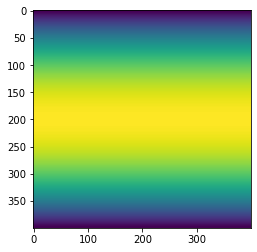

In [10]:
plt.imshow(beam.squeeze())

In [11]:
print("beam array shape is n_energies, nz, nx: %s"%str(beam.shape))
print("intensity range in projection image: %i to %i"%(beam.min(), beam.max()))

beam array shape is n_energies, nz, nx: (1, 400, 400)
intensity range in projection image: 5082 to 63535


### Make the Ground-Truth Phantom     
We will first create the phantom object with discrete labels:  
    (0 : voids; 1 : material)  
Then, we will define the material attenuation properties:  
    (void : air; material : rock)  
    
The choice of elements is quite arbitrary.  

In [12]:
# Define the phantom parameters  
mat_dict = {"air" : 0.00122, "silica" : 2.7}

vs = 0.0745*sp - 0.4428
phantom_params = {"void_frac" : [0.35, 0.15], \
                  "void_size" : [vs, 0.2]}

In [13]:
# make_porous_material is defined in the utils.py file in tomo_twin package  
t0 = time.time()
vol = make_porous_material(obj_shape, **phantom_params)
tot_time = (time.time() - t0)/60.0
print("Done in %.2f minutes"%tot_time)

Done in 0.32 minutes


(400, 400, 400)


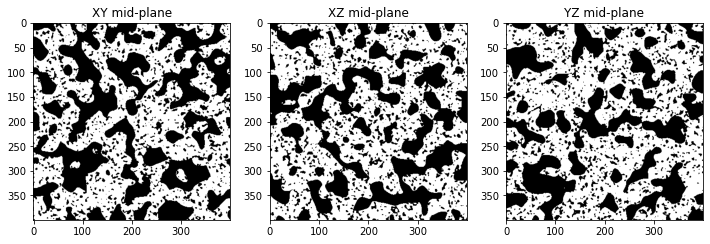

In [14]:
fig, ax = plt.subplots(1,3, figsize = (figw,figw/3))
h = viewer.view_midplanes(vol = vol, ax = ax) # ground truth (phantom)
print(vol.shape)

In [101]:
np.unique(vol)

array([0, 1], dtype=uint8)

In [41]:
SliceViewer(vol, vol)

interactive(children=(IntSlider(value=200, description='x', max=399), IntSlider(value=256, description='y', ma…

In [44]:
vol.shape

(400, 512, 512)

In [12]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
Ph = ray.Phantom(vol, mat_dict, res, energy_pts, data_path = material_data_path)

# Visualize input data

(400, 400, 400)


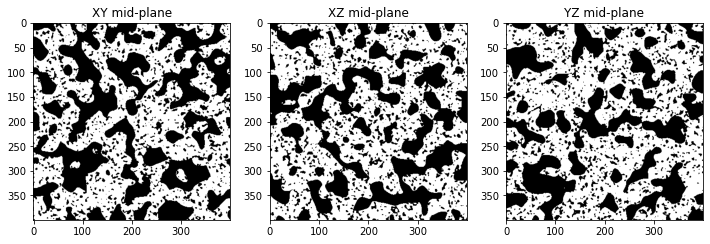

In [16]:
fig, ax = plt.subplots(1,3, figsize = (figw,figw/3))
h = viewer.view_midplanes(vol = Ph.vol, ax = ax) # ground truth (phantom)
print(Ph.vol.shape)

(1, 400, 400)

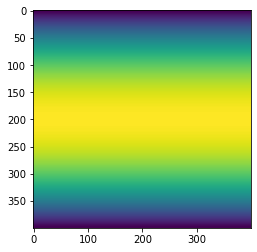

In [17]:
plt.imshow(beam.squeeze()) # flat field для источника
beam.shape # здесь flat field один и тот же

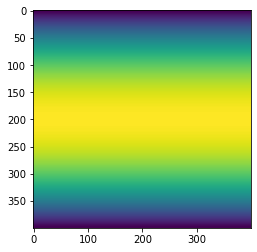

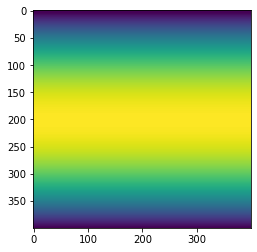

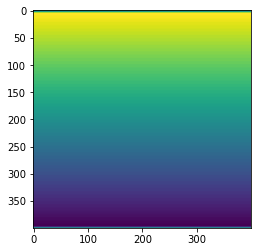

In [18]:
beam_image = beam.squeeze().copy()

beam_rolled = np.roll(beam_image, shift=2, axis=0)

plt.figure()
plt.imshow(beam_image)

plt.figure()
plt.imshow(beam_rolled)

plt.figure()
plt.imshow(beam_image - beam_rolled)

In [19]:
beam = beam_image.copy()[None, ...]

In [56]:
beam = beam_rolled.copy()[None, ...]

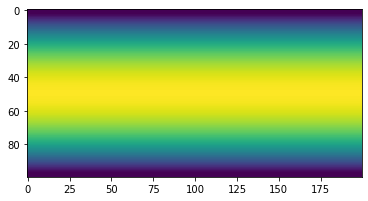

In [89]:
plt.imshow(beam.squeeze()) # flat field для источника

In [4]:
import numpy as np

f = np.load('./data/flat.npy')
f.shape

(30, 1024, 2448)

In [12]:
%cd TomoTwin

[WinError 2] Не удается найти указанный файл: 'TomoTwin'
C:\Users\dkoro\PythonProjects\TOMO\project\TomoTwin


No bin2


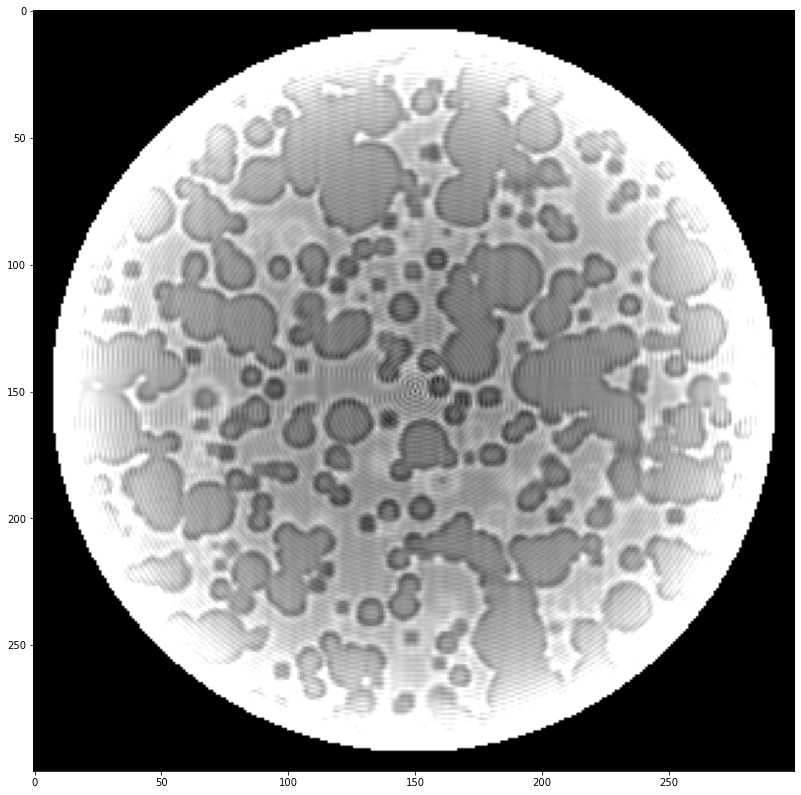

In [29]:
import json
import h5py
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from ct_segnet import viewer
from ct_segnet.stats import calc_SNR
from tomo_twin import ray
from tomo_twin.recon import *
from tomo_twin.gt_generators import make_porous_material, make_spheres
import os
import cv2


def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(42)


# ===================================== Ground Truth mask

class GroundTruthCreator():
    def __call__(self, volume_shape):
        pass

class PorousCreator(GroundTruthCreator):
    '''
        Create porouse ground truth mask
    '''
    def __init__(self, phantom_params):
        self.params = phantom_params
    
    def __call__(self, volume_shape):
        
        return make_porous_material(volume_shape, **phantom_params)


class GranulesCreator(GroundTruthCreator):
    '''
        Create granules ground truth mask
    '''
    def __init__(self, phantom_params):
        self.params = phantom_params
    
    def __call__(self, volume_shape):
        
        return make_spheres(volume_shape, **phantom_params)
        

# ===================================== Flat Field    
class FlatFieldCreator():
    def __call__(self, artifacts):
        pass

    
class FlatFieldFromNumpy(FlatFieldCreator):
    def __init__(self, source):
        self.source = source
    
    def __call__(self, artifacts):
        flat_field = np.load(self.source)
        
        shape = flat_field.shape
        
        # tiff, numpy
        
        # TODO create optioins (mean, random sample flat field)
        
        if len(shape) == 2:
            flat_field = np.expand_dims(flat_field, axis=0)
        
        return {'flat_field': flat_field}
        
    
class FlatFieldFromTomoTwinSource(FlatFieldCreator):
    def __init__(self, source, detector_options):
        self.detector_opt = detector_options
        self.source = source
    
    def __call__(self, artifacts):
    
        proj_shape = self.detector_opt['FOV']

        flat_field = ray.read_source(self.source, \
                           self.detector_opt['energy_pts'], \
                           res = self.detector_opt['pixel_size'], \
                           img_shape = proj_shape)
        
        return  {'flat_field': flat_field}

# ===================================== Phantom
class PhantomCreator():
    def __init__(self, detector_options: dict,
                 ground_truth_creator: GroundTruthCreator,
                 materials_dict: dict,
                 materials_path: str
                ):
        
        self.detector_opt = detector_options
        self.gt_creator = ground_truth_creator
        self.mat_dict = materials_dict
        self.materials_path = materials_path
    
    
    def __validate_materials(self, gt_volume):
        n_classes = len(np.unique(gt_volume))
        n_materials = len(self.mat_dict)
        if n_classes != n_materials:
            raise AssertionError(f'Num classes in gt volume != Num materials, {n_classes} != {n_materials}')
        
    def __call__(self, artifacts):
        
        proj_shape = self.detector_opt['FOV']
        
        vol_shape = (proj_shape[0], proj_shape[1], proj_shape[1])

        gt_volume = self.gt_creator(vol_shape)
        
        self.__validate_materials(gt_volume)
        
        phantom = ray.Phantom(gt_volume, self.mat_dict,
                     self.detector_opt['pixel_size'],
                     self.detector_opt['energy_pts'],
                     data_path = self.materials_path
                    )
        
        return {'gt_volume': gt_volume, 'phantom': phantom}

    
    
    
# =============================== Projections


class ProjectionsCreator:
    
    def __init__(self, detector_options):
        self.detector_opt = detector_options
    
    def __validate_flat_field(self, flat_field):
        f_shape = flat_field.shape
        fov = self.detector_opt['FOV']
        n_projs = self.detector_opt['n_projections']
        
        valid_shape1 = (1, *fov)
        
        assertion = (f_shape[0] == 1) & \
        (f_shape[1] == fov[0]) & \
        (f_shape[2] == fov[1])

        if not assertion:
            msg = f'Invalid flat field shape: {f_shape}, must be ' \
                  f'{valid_shape1} '
            raise AssertionError(msg)
        
    def __sample_flat_field(self, flat_field):
        samples = flat_field.shape[0]
        flat_field_sample = flat_field[random.randint(0, samples-1), :, :]
        flat_field_sample = cv2.resize(flat_field_sample,  self.detector_opt['FOV'])
        flat_field_sample = np.expand_dims(flat_field_sample, axis=0)
        return flat_field_sample
    
    def __call__(self, artifacts):
        
        flat_field = artifacts['flat_field']
        phantom = artifacts['phantom']
        
        theta = (*self.detector_opt['projections_range'], self.detector_opt['n_projections'])
        
#         flat_field_sample = self.__sample_flat_field(flat_field)
            
        self.__validate_flat_field(flat_field)
        
#         print(flat_field_sample.shape)
        
        proj_beam, projs = phantom.get_projections(theta = theta, beam = flat_field, \
                               noise = self.detector_opt['noise'], \
                               detector_dist = self.detector_opt['detector_dist'], \
                               blur_size = self.detector_opt['blur_size'])
        
        return {'projections': projs, 'proj_beam': proj_beam, 'theta': theta, 'proj_flat_field': flat_field}

    
class ReconReconstruction:
    '''
        Reconstruction from TOMO twin
    '''
    def __init__(self, reconstruction_options, detector_options):
        self.recon_ops = reconstruction_options
        self.detector_opt = detector_options
    
#     def __sample_flat_field(self, flat_field):
#         samples = flat_field.shape[0]
#         flat_field_sample = flat_field[random.randint(0, samples-1), :, :]
#         flat_field_sample = cv2.resize(flat_field_sample,  self.detector_opt['FOV'])
#         flat_field_sample = np.expand_dims(flat_field_sample, axis=0)
#         return flat_field_sample
    
    def __call__(self, artifacts):
        projs = artifacts['projections']
        flat_field = artifacts['flat_field']
        theta = artifacts['theta']
        
#         flat_field_sample = self.__sample_flat_field(flat_field)
                
        reconstructed = recon_wrapper(projs, flat_field, theta, pad_frac=self.recon_ops['pad_frac'],
                                  mask_ratio=self.recon_ops['mask_ratio'], contrast_s=self.recon_ops['contrast_s'])
    
        return {'reconstructed': reconstructed, 'recon_flat_field': flat_field}

    
    
# =============================== add domain augmentations


class Augmentation:
    def __call__(self, artifacts):
        pass

class RingsAugmentation(Augmentation):
    '''
        Create ring by affecting flat_field
    '''
    def __init__(self, detector_options, shift=3):
        self.detector_opt = detector_options
        self.shift = shift
    
    def __call__(self, artifacts):
        
        n_projections = self.detector_opt['n_projections']
        flat_field = artifacts['flat_field']
        
        flat_field = np.roll(flat_field, self.shift, axis=1)
        
        return {'flat_field': flat_field}
        

# ================================ visualization

def show_mid_volume(volume, figsize=(12, 4)):
    fig, ax = plt.subplots(1,3, figsize=figsize)
    viewer.view_midplanes(vol = volume, ax = ax)

    
# ================================ compose
class Compose():
    
    def __init__(self, operations: list):
        self.operations = operations
    
    def __call__(self):
        
        all_artifacts = {}
        for op in self.operations:
            artifacts = None
            if isinstance(op, list):
                artifacts = {}
                for sub_op in op:
                    res = sub_op(all_artifacts)
                    artifacts.update(res)
            else:
                artifacts = op(all_artifacts)
            
            # TODO add stage info
            assert artifacts is not None, 'Results in stage is None'
            all_artifacts.update(artifacts)

        return all_artifacts

class RandomOptions():
    
    def __init__(self):
        self.options = None
        self.available_options = None
        self.artifact_key = None
        self.mutable_options = None
        self.call_options = None
                        
    def __call__(self, artifacts):
        
        res_options = {}
        
        for name, opt in self.options.items():
            
            opt_value = opt
            
            if name not in self.available_options:
                msg = f'Invalid option {name}, valid options are {self.available_options}'
                raise AssertionError(msg)
            
            if name in self.mutable_options:
                if isinstance(opt, (list, tuple)):
                    if len(opt) != 2:
                        msg = f'Valid options must be of lenght two: (start, end)'
                        raise AssertionError(msg)

                    opt_value = random.uniform(opt[0], opt[1])
            
            res_options[name] = opt_value
         
        self.call_options = res_options
        
        return {self.artifact_key: self.call_options}
    
    def __getitem__(self, key):
        return self.call_options[key]
    
    
                    
                        
class DetectorOptions(RandomOptions):
    
    def __init__(self, options):
        self.options = options
        
        self.available_options = [
            'detector_dist',
            'blur_size',
            'noise',
            'energy_pts',
            'pixel_size',
            'n_projections',
            'projections_range',
            'FOV'
        ]
        
        self.mutable_options = [
            'detector_dist',
            'blur_size',
            'noise'
        ]
        
        self.artifact_key = 'detector_options'
    
class ReconstructionOptions(RandomOptions):
    def __init__(self, options):
        self.options = options
        
        self.available_options = [
            'pad_frac',
            'mask_ratio',
            'contrast_s'
        ]
        
        self.mutable_options = [
            'contrast_s'
        ]
        
        self.artifact_key = 'reconstruction_options'


# Gt options Generator

        
def get_atrtifacts_names():
    '''
        'gt_volume': np.array,  (GT) ground truth volume with values 0 ... num_classes
        'phantom':   Phantom, class from tomotwin (GT with materials)
        'flat_field': np.array, Flat field array
        'theta': tuple, (start_angle, end_angle, n_projections)
        'projections': np.array, projections
        'reconstructed': reconstructed sample
    '''
    
    return {'gt_volume',
            'phantom',   
            'flat_field',
            'theta',
            'projections',
            'reconstructed'  
    }
        
    
# Ground Truth (num_classes)-->  Add materials (air, silica) --> Create projections  --> Reconstruction
#    -- porous              -->  Flat field                          -- noise                -- padding
#    -- granules                     -- from numpy                   -- blur                 -- cirlce mask
#                                    -- from tomotwin                -- detector distance    -- contrast change
#                                                                    -- n_projections
    
    
    
# detector parameters
detector_options = DetectorOptions({'detector_dist': 6.0, # detector distance in cm
                    'blur_size': 5, # kernel blur size
                    'noise': 0.0, # detector noise (0.0 to see the rings) 1.0 default
                    'energy_pts': 30.0, # keV
                    'pixel_size': 0.7, # res
                    
                    'n_projections': 500,
                    'projections_range': (0, 180),
                    'FOV': (300,300)
                   })

# reconstruction parameters
reconstruction_options = ReconstructionOptions({
                 'pad_frac': 0.8,
                 'mask_ratio': 0.95,
                 'contrast_s': (0.01, 0.05)
                })



# Define the phantom parameters  
materials_dict = {"air" : 0.00122, "silica" : 2.7}
sp = 18
vs = 0.0745*sp - 0.4428
# phantom_params = {"void_frac" : [0.35, 0.15], \
#                   "void_size" : [vs, 0.2]}






# porous
phantom_params = {"void_frac" : [0.1, 0.0], \
                  "void_size" : [vs, 0.2]}
# circles
phantom_params = {'void_frac': 0.5, 'radius': 8, 'radius_std': 4}



data_path = 'C:/Users/dkoro/PythonProjects/TOMO/project/TomoTwin/'
beam_source = os.path.join(data_path, 'model_data/source_files/7BM/beam_profile_7BM.hdf5')
materials_path = os.path.join(data_path, 'model_data')

            
compose = Compose([
                    [detector_options, reconstruction_options],
    
                    # create input data: gt_volume, phantom, flat_field
                    [PhantomCreator(detector_options,
                                  GranulesCreator(phantom_params), # PorousCreator(phantom_params),
                                  materials_dict, materials_path
                                 ), FlatFieldFromTomoTwinSource(beam_source, detector_options)], # FlatFieldFromTomoTwinSource(beam_source, detector_options)
                
                    # create projections: projections
                    ProjectionsCreator(detector_options),
                    
                    # add augmentations
                    RingsAugmentation(detector_options, shift=-50), # affect flat_field
    
                    # reconstruct phantom: reconstructed
                    ReconReconstruction(reconstruction_options, detector_options)
                  ])

samples = []

for i in range(10):
    sample = compose()
    
    plt.figure(figsize=(14, 14))
    plt.imshow(sample['reconstructed'][40, :, :], cmap='gray')
    
    np.save(f'sample{i}.npy', sample)
    samples.append(sample)
    
# TODO
# time function to move flat field during get_projections
# save sample 

In [34]:
sample_loaded = np.load('sample0.npy', allow_pickle=True)
print(sample_loaded.item().keys())    
print(sample_loaded.item().get('detector_options'))
print(sample_loaded.item().get('gt_volume'))

dict_keys(['detector_options', 'reconstruction_options', 'gt_volume', 'phantom', 'flat_field', 'projections', 'proj_beam', 'theta', 'proj_flat_field', 'reconstructed', 'recon_flat_field'])
{'detector_dist': 6.0, 'blur_size': 5, 'noise': 0.0, 'energy_pts': 30.0, 'pixel_size': 0.7, 'n_projections': 500, 'projections_range': (0, 180), 'FOV': (300, 300)}
[[[ True  True  True ...  True  True  True]
  [False False False ...  True  True  True]
  [False False False ... False False False]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[False False False ...  True  True  True]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False 

In [ ]:
samples

No bin2
No bin2


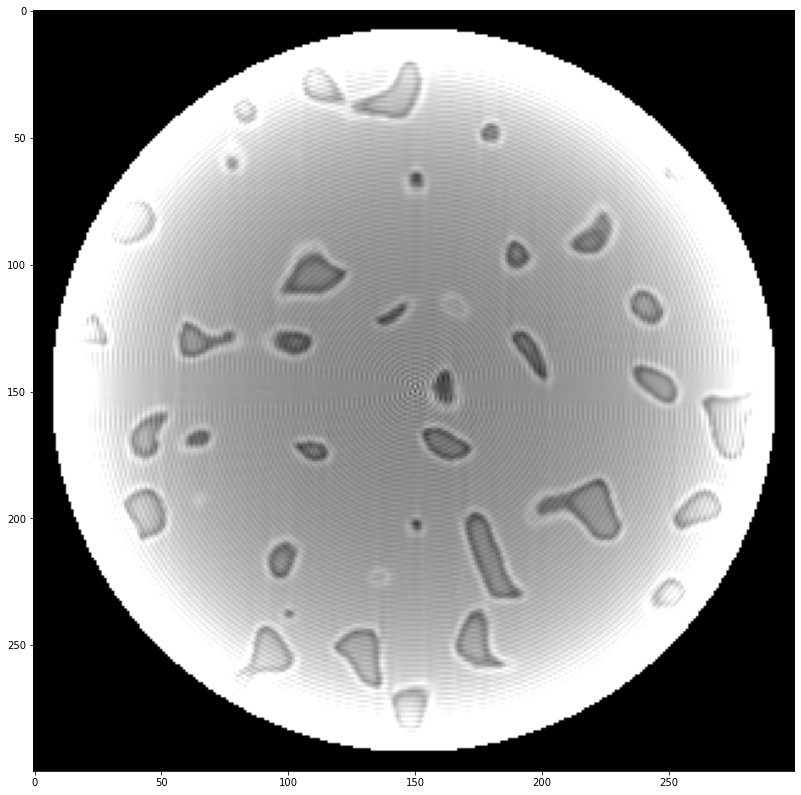

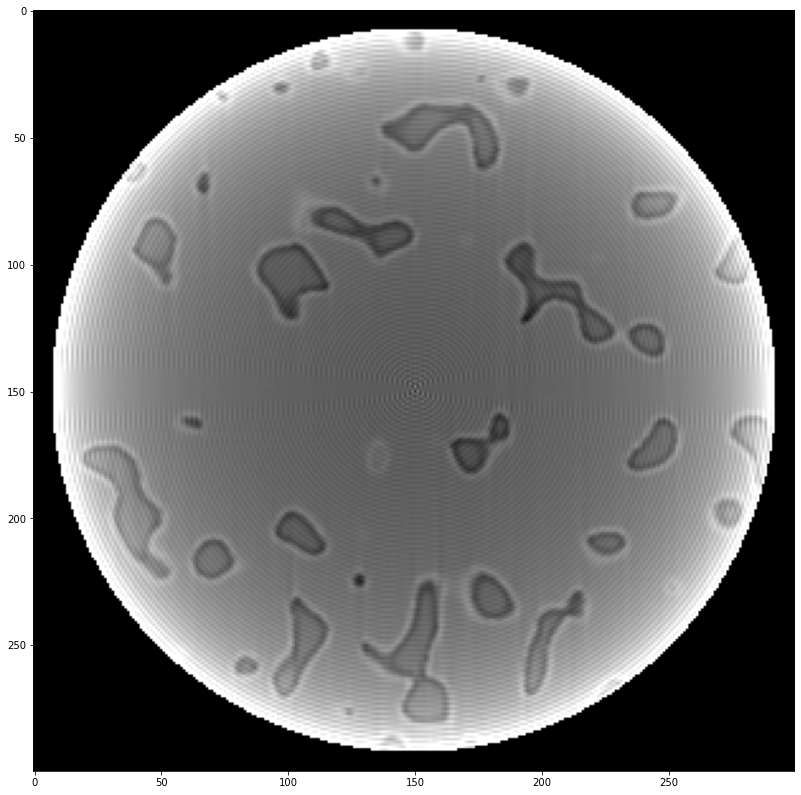

In [3]:
sample = sample_rings

In [4]:
sample['proj_beam'].shape

(500, 300, 300)

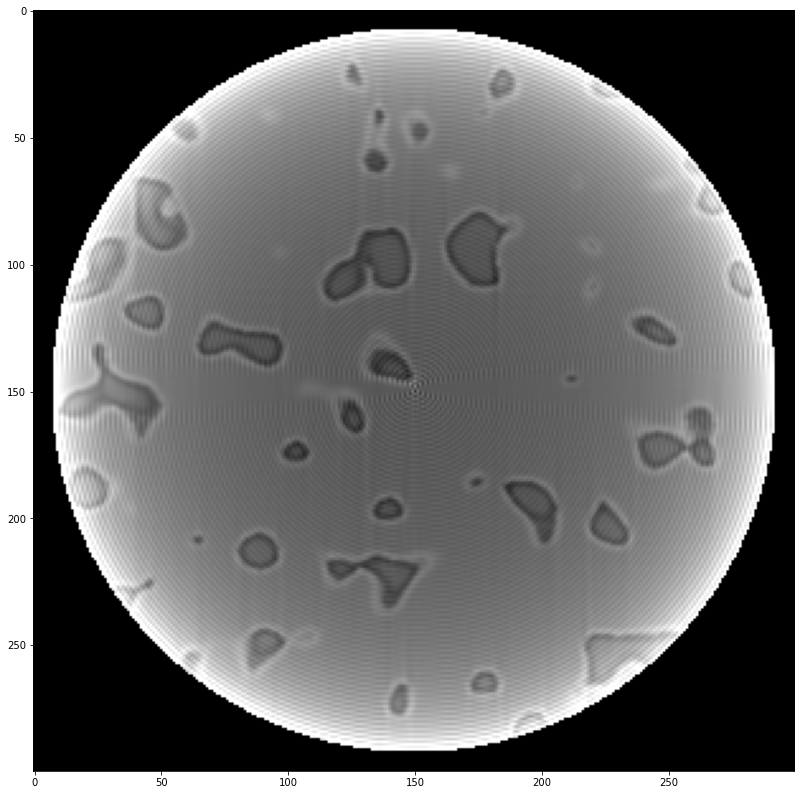

In [20]:
plt.figure(figsize=(14, 14))
plt.imshow(sample['reconstructed'][40, :, :], cmap='gray')

In [8]:
sample.keys()

dict_keys(['gt_volume', 'phantom', 'flat_field', 'projections', 'theta', 'reconstructed'])

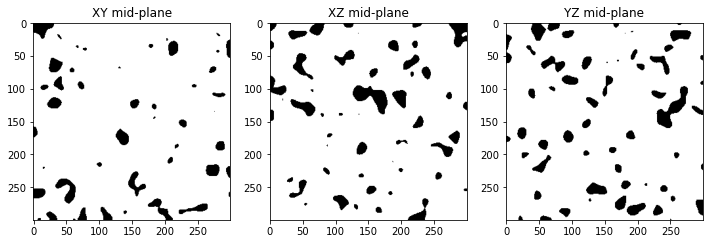

In [6]:
show_mid_volume(sample['gt_volume'], figsize=(12, 4))

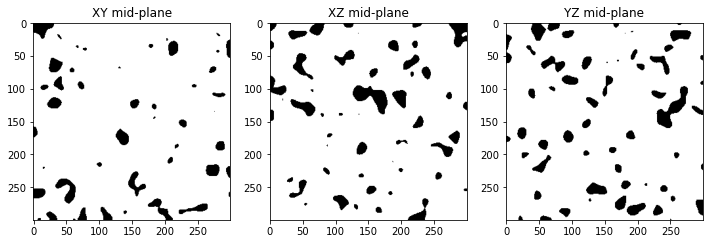

In [7]:
show_mid_volume(sample['phantom'].vol, figsize=(12, 4))

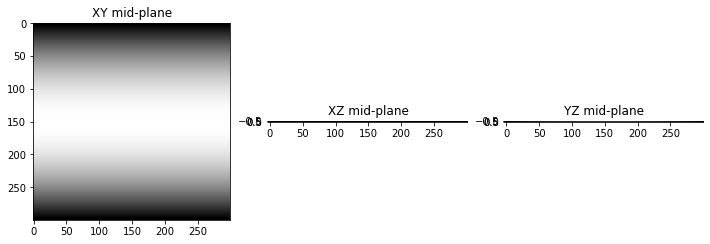

In [8]:
show_mid_volume(sample['flat_field'], figsize=(12, 4))

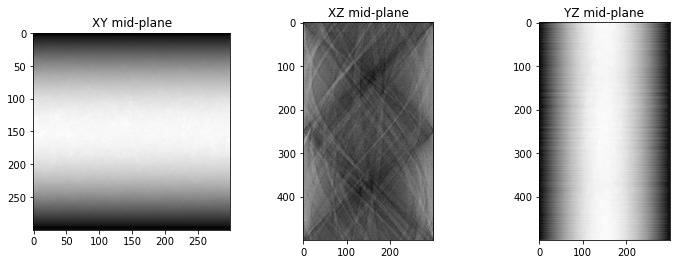

In [9]:
show_mid_volume(sample['projections'], figsize=(12, 4))

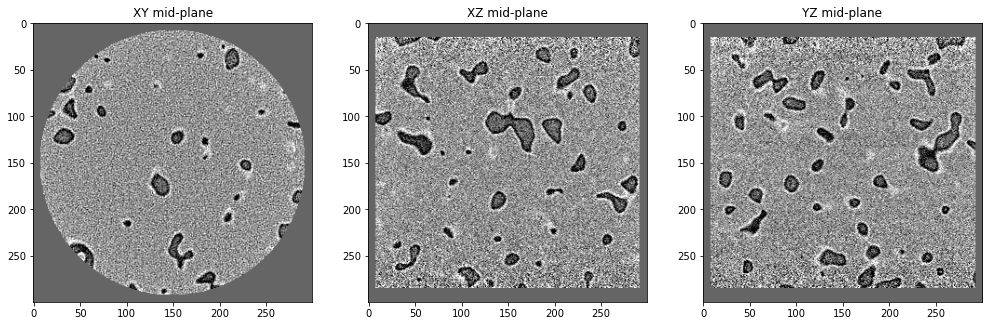

In [11]:
show_mid_volume(sample['reconstructed'], figsize=(17, 17))

In [24]:
f_sample = FlatFieldFromTomoTwinSource(beam_source, detector_options)(None)
f_sample['flat_field']

array([[[5082.8, 5082.8, 5082.8, ..., 5082.8, 5082.8, 5082.8],
        [5082.8, 5082.8, 5082.8, ..., 5082.8, 5082.8, 5082.8],
        [5082.8, 5082.8, 5082.8, ..., 5082.8, 5082.8, 5082.8],
        ...,
        [5082.8, 5082.8, 5082.8, ..., 5082.8, 5082.8, 5082.8],
        [5082.8, 5082.8, 5082.8, ..., 5082.8, 5082.8, 5082.8],
        [5082.8, 5082.8, 5082.8, ..., 5082.8, 5082.8, 5082.8]]])

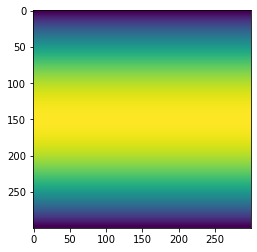

In [25]:
# min(falt_field) noise, one pixel
f = f_sample['flat_field'].squeeze()
plt.imshow(f)

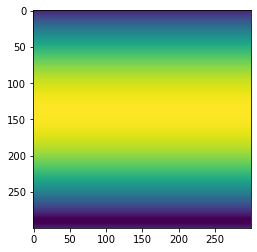

In [29]:
x = np.roll(f, -10, axis=0)
plt.imshow(x)

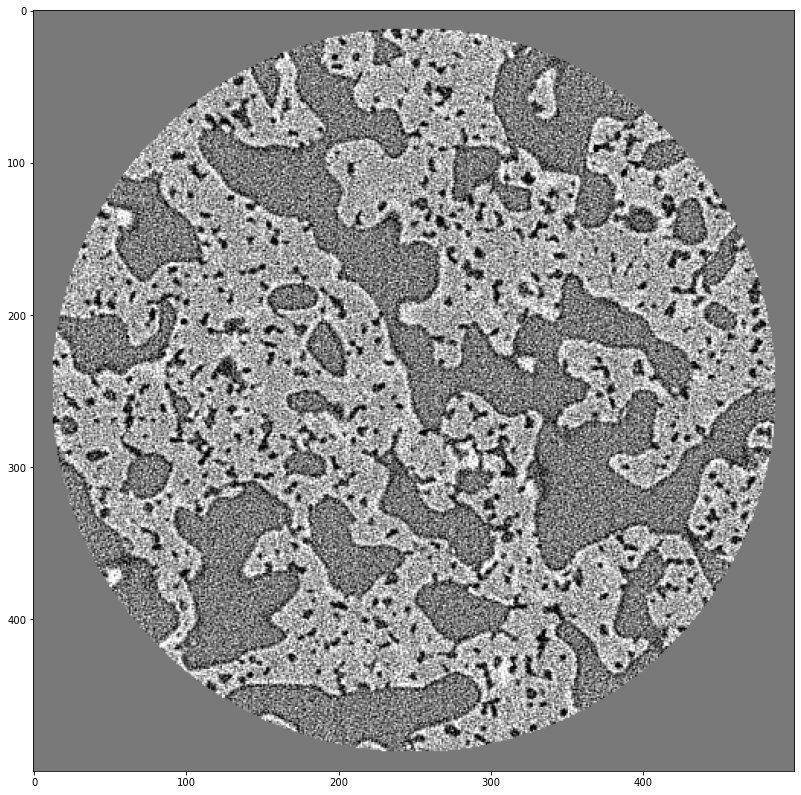

In [73]:
plt.figure(figsize=(14, 14))
plt.imshow(sample['reconstructed'][40, :, :], cmap='gray')

In [64]:
sample['reconstructed'].shape

(400, 500, 500)

In [ ]:
show_mid_volume(sample[''], figsize=(12, 4))

Projections !!!!!!!!!!!!!!!!23
(500, 400, 400)
(1, 400, 400)
Shape of the synthesized projections data: (500, 400, 400)
Done in 3.69 minutes
Create rings


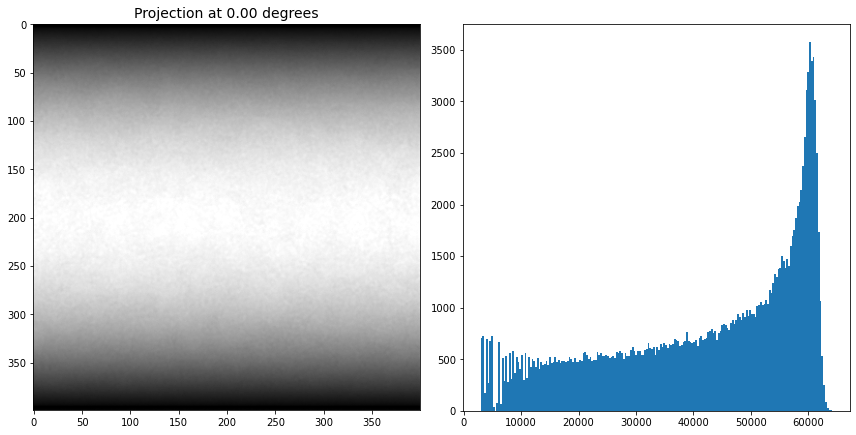

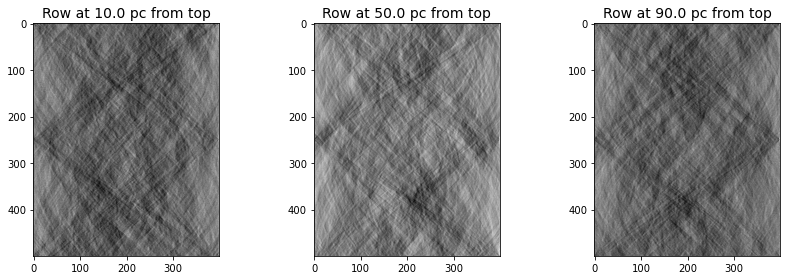

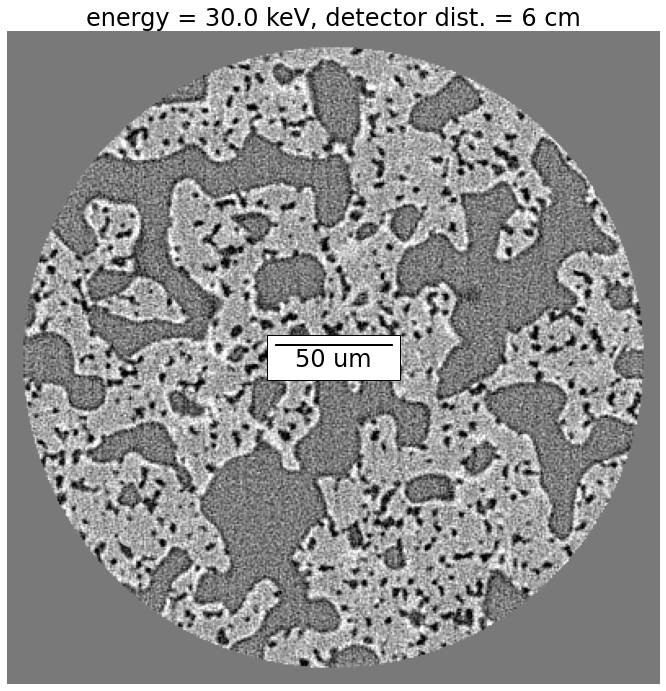

In [12]:
import json
import h5py
import random

%matplotlib inline
# pip package imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

figw = 12

from ct_segnet import viewer
from ct_segnet.stats import calc_SNR
from tomo_twin import ray
from tomo_twin.recon import *
from tomo_twin.gt_generators import make_porous_material
import os


def prepare_input_data(beam_source, detector_options, phantom_params, mat_dict, material_data_path):
    
    proj_shape = detector_options['FOV']
    
    beam = ray.read_source(beam_source, \
                       detector_options['energy_pts'], \
                       res = detector_options['pixel_size'], \
                       img_shape = proj_shape)
    
    
    obj_shape = (proj_shape[0], proj_shape[1], proj_shape[1])
    
    gt_volume = make_porous_material(obj_shape, **phantom_params)
    
    Ph = ray.Phantom(gt_volume, mat_dict,
                     detector_options['pixel_size'],
                     detector_options['energy_pts'],
                     data_path = material_data_path
                    )
    return gt_volume, beam, Ph


def create_projections(phantom: ray.Phantom,
                       projections_degrees_range: tuple,
                       flat_field_volume: np.ndarray,
                       detector_options,
                      ):

    '''
        phantom: Phantom class from TomoTwin
        projections_degrees_range: (start_angle,end_angle,projections_count)
        flat_field_volume:  flat-field (beam array) must be provided with shape (1, nrows, ncols) or (n_energies, nrows, ncols)
        detector_options: dict {'detector_dist': detector distance in cm, 'blur_size': blur kernel size, 'noise': multiplier to noise std. dev. 1.0 is perfect Poisson dist}
            Example: {'detector_dist': 6.0, 'blur_size': 5 'noise': 1.0}
    '''
    

        
    t0 = time.time()

    projs = phantom.get_projections(theta = projections_degrees_range, beam = flat_field_volume, \
                               noise = detector_options['noise'], \
                               detector_dist = detector_options['detector_dist'], \
                               blur_size = detector_options['blur_size'])
    
    tot_time = (time.time() - t0)/60.0
    print("Shape of the synthesized projections data: %s"%str(projs.shape))
    print("Done in %.2f minutes"%tot_time)
    
    return projs

def show_projections(projections, figw, projections_degrees_range, projection_index=0):
    
    theta = np.linspace(*projections_degrees_range, endpoint = True)
    
    img_show = projections[projection_index].copy()
    img_show = np.clip(img_show, *modified_autocontrast(img_show, s = 0.01))
    fig, ax = plt.subplots(1,2, figsize = (figw,figw/2))
    h = ax[0].imshow(img_show, cmap = 'gray')
    h = ax[0].set_title("Projection at %.2f degrees"%theta[projection_index], fontsize = 14)
    h = ax[1].hist(projections[projection_index].reshape(-1), bins = 200)
    fig.tight_layout()


def show_sinograms(projections, select_rows=[0.1,0.5,0.9], figw=12):
    
    select_idx = [int(select_row*projections.shape[1]) for select_row in select_rows]
    fig, ax = plt.subplots(1,len(select_rows), figsize = (figw,figw/len(select_rows)))
    for ii, idx in enumerate(select_idx):
        ax[ii].imshow(projections[:,idx,:], cmap = 'gray')
        ax[ii].set_title("Row at %.1f pc from top"%(100.0*select_rows[ii]), fontsize = 14)
    fig.tight_layout()

def show_reconstruction(reconstructed, detector_options, figw=12):
    fig, ax = plt.subplots(1,1, figsize = (figw, figw))
    ax.imshow(reconstructed[reconstructed.shape[0]//2], cmap = 'gray')
    ax.set_title("energy = %.1f keV, detector dist. = %.0f cm"%(detector_options['energy_pts'], detector_options['detector_dist']), fontsize = 24)
    ax.axis('off')
    viewer.add_scalebar(ax, 50, detector_options['pixel_size'], fontsize = 24, loc = 'center')

    

def write_sample(output_fpath, projections, flat_field, material_dict, phantom_params, detector_config,
                gt_volume, reconstructed, output_config):
    
    hf = h5py.File(output_fpath, 'w')

    g = hf.create_group("res")
    d = g.create_dataset("projections", data=projections, dtype=np.uint16)
    d = g.create_dataset("data_bright", data=flat_field, dtype=np.uint16)
    d = g.create_dataset("data_dark", data=np.zeros_like(flat_field), dtype=np.uint16)
    
    gm = g.create_group("detector_config")
    
    for k, v in detector_config.items():
        gm.attrs[k] = v
    

    crop_slice, vcrop_slice = get_cropslices(gt_volume.shape, output_config['mask_ratio'])

    # save phantom
    g = hf.create_group("tomo")
    d = g.create_dataset("gt_labels", \
                         data = gt_volume[vcrop_slice, crop_slice, crop_slice], \
                         dtype = np.float32)
    d = g.create_dataset("recon", \
                         data = reconstructed[vcrop_slice, crop_slice, crop_slice], \
                         dtype = np.float32)
    gm = g.create_group("phantom")
    gm.attrs["output_fpath"] = output_fpath
    m = gm.create_dataset("mat_dict", data = json.dumps(material_dict))
    m = gm.create_dataset("phantom_params", data = json.dumps(phantom_params))
    
    hf.close()


def generate_sample(mat_dict, phantom_params, detector_options, beam_source, material_data_path, output_config, rings=True, show=True):
    


    gt_volume, beam, phantom = prepare_input_data(beam_source, detector_options, phantom_params, mat_dict, material_data_path)

    theta = (0,180,detector_options['n_projections'])
    
    # create projection
    projs = create_projections(phantom=phantom,
                               projections_degrees_range=theta,
                               flat_field_volume=beam,
                               detector_options=detector_options)
    if show:
        show_projections(projections=projs,
                         figw=12,
                         projections_degrees_range=theta,
                         projection_index=0)

        show_sinograms(projections=projs)
    
    if rings:
        f_size = detector_options['n_projections']
        rolled_list = []
        for i in range(f_size):
            rolled = np.roll(beam, 2, axis=0)
            rolled_list.append(rolled)
        beam = np.concatenate(rolled_list, axis=0)
        print('Create rings')
        
    # reconstruction
    reconstructed = recon_wrapper(projs, beam, theta, pad_frac=output_config['pad_frac'],
                                  mask_ratio=output_config['mask_ratio'], contrast_s=output_config['contrast_s'])
    
    if show:
        show_reconstruction(reconstructed=reconstructed, detector_options=detector_options, figw=12)
    
    
    return gt_volume, beam, projs, reconstructed
    

detector_config = {'detector_dist': 6.0, # detector distance in cm
                    'blur_size': 5, # kernel blur size
                    'noise': 1.0, # detector noise
                    'energy_pts': 30.0, # keV
                    'pixel_size': 0.7, # res
                    'n_projections': 500,
                    'FOV': (400,400)
                   }

output_config = {
                 'pad_frac': 0.8,
                 'mask_ratio': 0.95,
                 'contrast_s': 0.01
                }

# Define the phantom parameters  
material_dict = {"air" : 0.00122, "silica" : 2.7}
sp = 18
vs = 0.0745*sp - 0.4428
phantom_params = {"void_frac" : [0.35, 0.15], \
                  "void_size" : [vs, 0.2]}


data_path = 'C:/Users/dkoro/PythonProjects/TOMO/project/TomoTwin/'
beam_source = os.path.join(data_path, 'model_data/source_files/7BM/beam_profile_7BM.hdf5')
material_data_path = os.path.join(data_path, 'model_data')


gt_volume, beam, projs, reconstructed = generate_sample(material_dict, phantom_params, detector_config,
                                                        beam_source, material_data_path, output_config, show=True)


# np.save('./data/rolled2_beam.npy', rec)


data_path = "../data" # where to save the data  
if not os.path.exists(data_path): os.makedirs(data_path)

write_sample(output_fpath='./data/sample.hdf5',
             projections=projs,
             flat_field=beam,
             material_dict=material_dict,
             phantom_params=phantom_params,
             detector_config=detector_config,
             gt_volume=gt_volume,
             reconstructed=reconstructed,
             output_config=output_config)

# arrays
# Ph, beam, projs

In [ ]:
    hf = h5py.File(output_fpath, 'w')

    g = hf.create_group("res")
    d = g.create_dataset("projections", data=projections, dtype=np.uint16)
    d = g.create_dataset("data_bright", data=flat_field, dtype=np.uint16)
    d = g.create_dataset("data_dark", data=np.zeros_like(flat_field), dtype=np.uint16)
    
    gm = g.create_group("detector_config")
    
    for k, v in detector_config.items():
        gm.attrs[k] = v
    

    crop_slice, vcrop_slice = get_cropslices(gt_volume.shape, output_config['mask_ratio'])

    # save phantom
    g = hf.create_group("tomo")
    d = g.create_dataset("gt_labels", \
                         data = gt_volume[vcrop_slice, crop_slice, crop_slice], \
                         dtype = np.float32)
    d = g.create_dataset("recon", \
                         data = reconstructed[vcrop_slice, crop_slice, crop_slice], \
                         dtype = np.float32)
    gm = g.create_group("phantom")
    gm.attrs["output_fpath"] = output_fpath
    m = gm.create_dataset("mat_dict", data = json.dumps(material_dict))
    m = gm.create_dataset("phantom_params", data = json.dumps(phantom_params))

In [53]:
with h5py.File('./data/sample.hdf5', 'r') as hf:
    projs = hf['res']['projections'][:]
    beam_bright = hf['res']['data_bright'][:]
    beam_dark =  hf['res']['data_dark'][:]
    
    

[[[5082 5082 5082 ... 5082 5082 5082]
  [5082 5082 5082 ... 5082 5082 5082]
  [5082 5082 5082 ... 5082 5082 5082]
  ...
  [5082 5082 5082 ... 5082 5082 5082]
  [5082 5082 5082 ... 5082 5082 5082]
  [5082 5082 5082 ... 5082 5082 5082]]]


In [21]:
np.save('./data/rolled_random_beam.npy', rec)

In [5]:
%cd TomoTwin

C:\Users\dkoro\PythonProjects\TOMO\project\TomoTwin


In [ ]:
import pip
pip.main(['install', 'nibabel'])

In [6]:
from vtk.util import numpy_support
import vtk
import numpy as np

In [21]:
toslicer.shape

(400, 512, 512)

In [22]:
import numpy as np
import nibabel as nib

toslicer = np.load('./data/rolled_random_beam.npy')
#toslicer = np.load('./data/original_beam.npy')
img = nib.Nifti1Image(toslicer, np.eye(4))
img.get_data_dtype() == np.dtype(np.int16)
img.header.get_xyzt_units()
nib.save(img, './data/rolled_random_beam.nii.gz')  
#nib.save(img, './data/original_beam.nii.gz')  

In [16]:
import numpy as np
import nibabel as nib

data = np.ones((32, 32, 15, 100), dtype=np.int16)
img = nib.Nifti1Image(data, np.eye(4))
img.get_data_dtype() == np.dtype(np.int16)
img.header.get_xyzt_units()

('unknown', 'unknown')

In [17]:
nib.save(img, './data/test4d.nii.gz')  

In [11]:
writer = vtk.vtkArrayWriter()
writer.SetInputData(VTK_data.VTKObject)
writer.SetFileName('test.vtk')
writer.Update()

AttributeError: 'vtkmodules.vtkCommonCore.vtkFloatArray' object has no attribute 'VTKObject'

In [12]:
import numpy as np
from enthought.tvtk.api import tvtk, write_data

data = np.random.random((10,10,10))

grid = tvtk.ImageData(spacing=(10, 5, -10), origin=(100, 350, 200), 
                      dimensions=data.shape)
grid.point_data.scalars = np.ravel(order='F')
grid.point_data.scalars.name = 'Test Data'

# Writes legacy ".vtk" format if filename ends with "vtk", otherwise
# this will write data using the newer xml-based format.
write_data(grid, 'test.vtk')

ModuleNotFoundError: No module named 'enthought'

In [10]:
dir(VTK_data)

['AbstractArray',
 'AddObserver',
 'Allocate',
 'AoSDataArrayTemplate',
 'BreakOnError',
 'COMPONENT_RANGE',
 'ClearLookup',
 'CopyComponent',
 'CopyComponentNames',
 'CopyInformation',
 'CreateArray',
 'CreateDataArray',
 'CreateDefaultLookupTable',
 'DISCRETE_VALUES',
 'DISCRETE_VALUE_SAMPLE_PARAMETERS',
 'DataArray',
 'DataArrayTemplate',
 'DataChanged',
 'DebugOff',
 'DebugOn',
 'DeepCopy',
 'DeleteMethod',
 'ExportToVoidPointer',
 'FastDelete',
 'FastDownCast',
 'Fill',
 'FillComponent',
 'GUI_HIDE',
 'GetActualMemorySize',
 'GetAddressAsString',
 'GetArrayType',
 'GetClassName',
 'GetCommand',
 'GetComponent',
 'GetComponentName',
 'GetData',
 'GetDataSize',
 'GetDataType',
 'GetDataTypeAsString',
 'GetDataTypeMax',
 'GetDataTypeMin',
 'GetDataTypeRange',
 'GetDataTypeSize',
 'GetDataTypeValueMax',
 'GetDataTypeValueMin',
 'GetDebug',
 'GetElementComponentSize',
 'GetFiniteRange',
 'GetGlobalWarningDisplay',
 'GetInformation',
 'GetLookupTable',
 'GetMTime',
 'GetMaxDiscreteValue

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets.widgets import *
from ipywidgets import widgets
from IPython.display import display

class SliceViewer():

    '''
        Arguments: 
            traces_volume - np.array with shape (nx, ny, nz)
            labels_volume - np.array with shape (nx, ny, nz)
            figsize - tuple, plot size

    '''

    def __init__(self, traces_volume, labels_volume,
                 figsize=(7, 7), tr_cmap='gray', lb_cmap='Greens'):

        assert traces_volume.shape == labels_volume.shape, 'Shapes must be equal'

        self.tr_volume = traces_volume
        self.lb_volume = labels_volume
        self.figsize = figsize
        self.tr_cmap = tr_cmap
        self.lb_cmap = lb_cmap

        self.nx, self.ny, self.nz = self.tr_volume.shape

        self.widget = self.__create_widget()


    def __create_widget(self):

        x_slider = IntSlider(min=0, max=self.nx - 1, step=1, value=int(self.nx/2))
        y_slider = IntSlider(min=0, max=self.ny - 1, step=1, value=int(self.ny/2))
        z_slider = IntSlider(min=0, max=self.nz - 1, step=1, value=int(self.nz/2))
        alpha = IntSlider(min=0, max=100, step=5, value=70)
        selector = ['x','y','z']
        w = interact(self.__show, x=x_slider, y=y_slider,
                     z=z_slider, alpha=alpha, dim=selector)

        return w

    
    def __get_slice(self, x, y, z, dim):

        if dim == 'x':
            tr = self.tr_volume[x, :, :]
            lb = self.lb_volume[x, :, :]
        elif dim == 'y':
            tr = self.tr_volume[:, y, :]
            lb = self.lb_volume[:, y, :]
        else:
            tr = self.tr_volume[:, :, z]
            lb = self.lb_volume[:, :, z]
        
        return tr, lb


    def __set_labels(self, ax, dim):

        if dim == 'x':
            ax.set_xlabel('y')
            ax.set_ylabel('z')
        elif dim == 'y':
            ax.set_xlabel('x')
            ax.set_ylabel('z')
        else:
            ax.set_xlabel('y')
            ax.set_ylabel('x')

    
    def __show(self, x, y, z, alpha, dim):

        tr, lb = self.__get_slice(x, y, z, dim)

        fig, ax = plt.subplots(figsize=self.figsize)
        plt.imshow(tr.T, cmap=self.tr_cmap, aspect='equal')
        plt.imshow(lb.T, alpha=(100-alpha)/100, aspect='equal', cmap=self.lb_cmap)
        self.__set_labels(ax, dim)
        plt.grid()
        plt.show()
        display()

        ax.set_xlabel('x')
        ax.set_ylabel('z')

In [28]:
SliceViewer(Ph.vol, Ph.vol)

interactive(children=(IntSlider(value=200, description='x', max=399), IntSlider(value=256, description='y', ma…

In [50]:
Ph.vol.shape

(100, 100, 100)

### Synthetize Projections  

In [55]:
theta = (0,180,50)

In [56]:
t0 = time.time()
projs = Ph.get_projections(theta = theta, beam = beam, \
                           noise = noise, \
                           detector_dist = detector_dist, \
                           blur_size = blur_size)
tot_time = (time.time() - t0)/60.0
print("Shape of the synthesized projections data: %s"%str(projs.shape))
print("Done in %.2f minutes"%tot_time)

Shape of the synthesized projections data: (50, 100, 100)
Done in 0.16 minutes


In [63]:
projs.shape

(50, 100, 100)

In [74]:
modified_autocontrast

<function tomo_twin.recon.modified_autocontrast(vol, s=0.01)>

### View Projections  

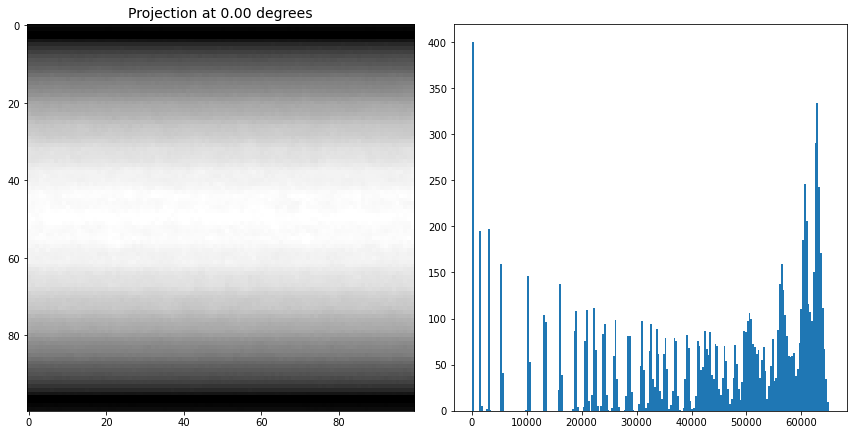

In [72]:
img_show = projs[0].copy()
img_show = np.clip(img_show, *modified_autocontrast(img_show, s = 0.01))
fig, ax = plt.subplots(1,2, figsize = (figw,figw/2))
h = ax[0].imshow(img_show, cmap = 'gray')
h = ax[0].set_title("Projection at %.2f degrees"%theta[0], fontsize = 14)
h = ax[1].hist(projs[0].reshape(-1), bins = 200)
# h = ax[1].imshow(projs[-1], cmap = 'gray')
# h = ax[1].set_title("Projection at %.2f degrees"%theta[1], fontsize = 14)
fig.tight_layout()

### View Sinograms  

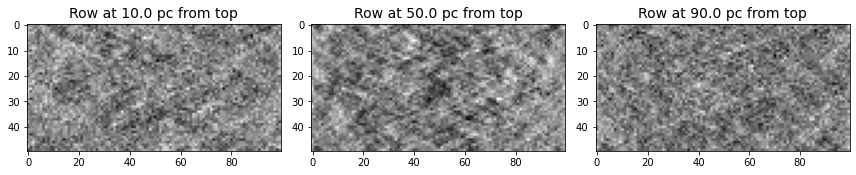

In [73]:
select_rows = [0.1,0.5,0.9]
select_idx = [int(select_row*projs.shape[1]) for select_row in select_rows]
fig, ax = plt.subplots(1,len(select_rows), figsize = (figw,figw/len(select_rows)))
for ii, idx in enumerate(select_idx):
    ax[ii].imshow(projs[:,idx,:], cmap = 'gray')
    ax[ii].set_title("Row at %.1f pc from top"%(100.0*select_rows[ii]), fontsize = 14)
fig.tight_layout()

### Do a test reconstruction with gridrec  

In [64]:
mask_ratio = 0.95
contrast_s = 0.01
rec = recon_wrapper(projs, beam, theta, pad_frac = 0.8, mask_ratio = mask_ratio, contrast_s = contrast_s)

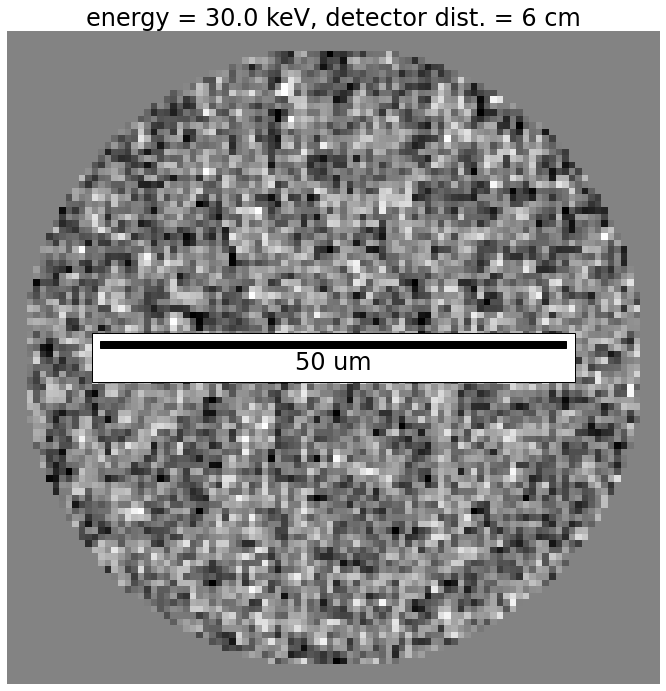

In [65]:
fig, ax = plt.subplots(1,1, figsize = (figw, figw))
ax.imshow(rec[rec.shape[0]//2], cmap = 'gray')
ax.set_title("energy = %.1f keV, detector dist. = %.0f cm"%(energy_pts, detector_dist), fontsize = 24)
ax.axis('off')
viewer.add_scalebar(ax, 50, res, fontsize = 24, loc = 'center')

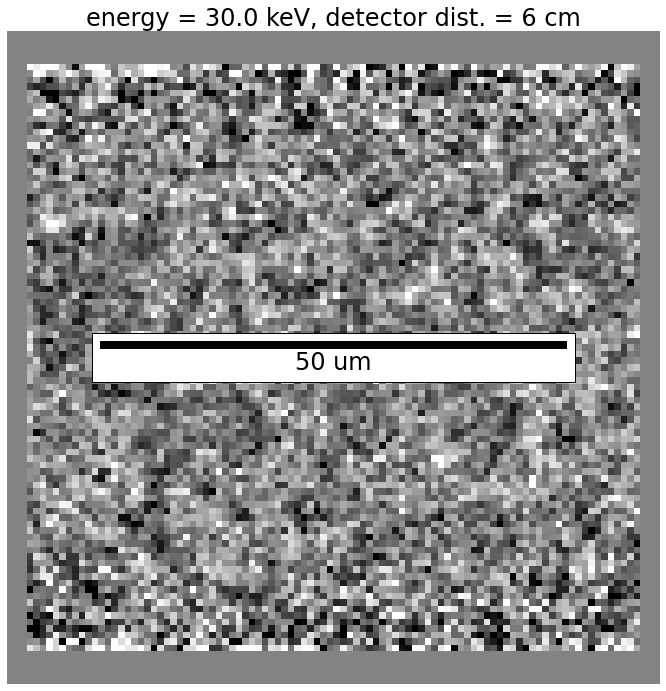

In [66]:
fig, ax = plt.subplots(1,1, figsize = (figw, figw))
ax.imshow(rec[:,rec.shape[1]//2], cmap = 'gray')
ax.set_title("energy = %.1f keV, detector dist. = %.0f cm"%(energy_pts, detector_dist), fontsize = 24)
ax.axis('off')
viewer.add_scalebar(ax, 50, res, fontsize = 24, loc = 'center')

Text(0.5, 1.0, 'SNR = 0.85')

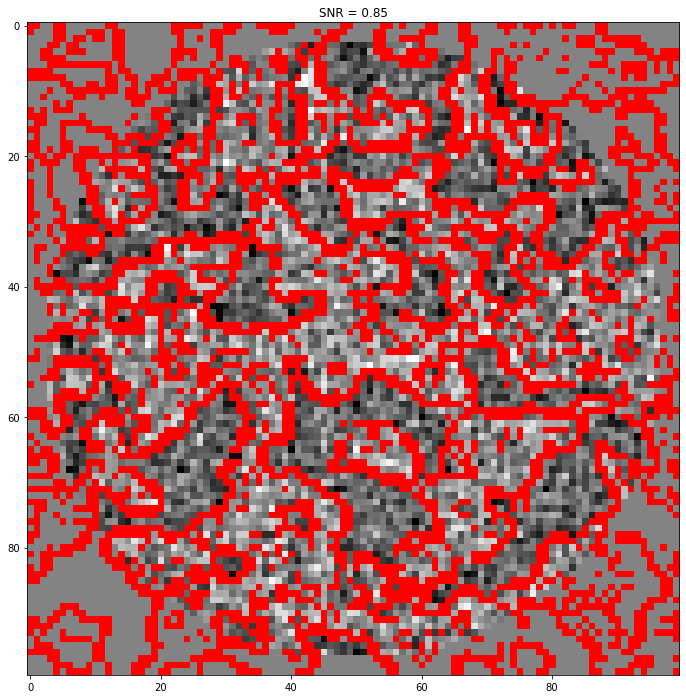

In [67]:
fig, ax = plt.subplots(1,1, figsize = (figw, figw))
idx_mid = int(rec.shape[0]//2)
viewer.edge_plot(rec[idx_mid], vol[idx_mid] > 0, ax = ax, color = [255,0,0])
ax.set_title("SNR = %.2f"%calc_SNR(rec[idx_mid], vol[idx_mid], labels = (0,1), mask_ratio = mask_ratio))

In [19]:
SNR_voids = calc_SNR(rec, vol, labels = (0,1), mask_ratio = mask_ratio)
print("SNR of material against voids: %.2f"%SNR_voids)

SNR of material against voids: 1.65


**Comments:** In this example, that there are two signal-noise ratios (SNR) to be evaluated: the contrast between the material and voids in background and the contrast between the inclusions against the material background. Depending on the attenuation properties of the materials, these may be very different.  

## Save Data Pairs  

We will save the following:  
1. Ground-truth labeled phantom (nz, ny, nx): Label 0 is void, label 1 is material, label 2 is inclusion material.  
2. Projection data: 16 bit data (n_projections, nrows, ncolumns).  
Note that ny = nx = ncolumns and nrows = nz.  
3. Test reconstruction: float (nz, ny, nx)  

Tips to save metadata:  
https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/  

In [ ]:
import json
import h5py


def write_sample(output_fpath, projections, flat_field, material_dict, phantom_params, detector_config,
                gt_volume, reconstructed, output_config):
    
    hf = h5py.File(output_fpath, 'w')

    g = hf.create_group("exchange")
    d = g.create_dataset("data", data=projections, dtype=np.uint16)
    d = g.create_dataset("data_bright", data=flat_field, dtype=np.uint16)
    d = g.create_dataset("data_dark", data=np.zeros_like(flat_field), dtype=np.uint16)
    
    gm = g.create_group("detector_config")
    
    for k, v in detector_config.items():
        gm.attrs[k] = v
    

    crop_slice, vcrop_slice = get_cropslices(gt_volume.shape, output_config['mask_ratio'])

    # save phantom
    g = hf.create_group("tomo")
    d = g.create_dataset("gt_labels", \
                         data = gt_volume[vcrop_slice, crop_slice, crop_slice], \
                         dtype = np.float32)
    d = g.create_dataset("recon", \
                         data = reconstructed[vcrop_slice, crop_slice, crop_slice], \
                         dtype = np.float32)
    gm = g.create_group("phantom")
    gm.attrs["output_fpath"] = output_fpath
    m = gm.create_dataset("mat_dict", data = json.dumps(material_dict))
    m = gm.create_dataset("phantom_params", data = json.dumps(phantom_params))
    
    hf.close()

In [20]:
import json
import h5py

In [21]:
fname = "%s.hdf5"%sample_tag
fpath = os.path.join(data_path, fname)
hf = h5py.File(fpath, 'w')

In [22]:
# save exchange/data, exchange/data_bright and data_dark
g = hf.create_group("exchange")
d = g.create_dataset("data", data = projs, dtype = np.uint16)
d = g.create_dataset("data_bright", data = beam, dtype = np.uint16)
d = g.create_dataset("data_dark", data = np.zeros_like(beam), dtype = np.uint16)

In [23]:
# save exchange/measurement
gm = g.create_group("measurement")
gm.attrs["pixel_size"] = res
gm.attrs["energy"] = energy_pts
gm.attrs["detector_dist"] = detector_dist
gm.attrs["n_projections"] = n_projections
gm.attrs["noise_level"] = noise
gm.attrs["blur_kernel"] = blur_size

In [24]:
crop_slice, vcrop_slice = get_cropslices(vol.shape, mask_ratio)

# save phantom
g = hf.create_group("tomo")
d = g.create_dataset("gt_labels", \
                     data = vol[vcrop_slice, crop_slice, crop_slice], \
                     dtype = np.float32)
d = g.create_dataset("recon", \
                     data = rec[vcrop_slice, crop_slice, crop_slice], \
                     dtype = np.float32)
gm = g.create_group("phantom")
gm.attrs["sample_tag"] = sample_tag
m = gm.create_dataset("mat_dict", data = json.dumps(mat_dict))
m = gm.create_dataset("phantom_params", data = json.dumps(phantom_params))

In [25]:
hf.close()

In [26]:
time.ctime()

'Thu Mar 18 17:34:13 2021'